In [108]:
import numpy as np
import pandas as pd

from importlib import reload
import copy
import synthetic.render.generator as gen

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import images

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'
data = fio.read(catalog_path)
catalog_cluster = data[data['LOC'] == 1]
catalog_field = data[data['LOC'] == 0]

In [5]:
catalog = np.hstack((catalog_cluster, catalog_field))
catalog = np.hstack((catalog_cluster, catalog_field))
catalog['G1'] += 0.05
catalog['G2'] += -0.02

In [6]:
df = render.DrawField(5000, catalog, band="i")
df.prepare()
df.make_infodicts()
df.multi_render(100)
df.collate_stamps()

starting xshear calculations in 100 processes


In [8]:
noise_std = 8.36335 / 4
noise = np.random.normal(scale=noise_std, size=(5000, 5000))

Text(0, 0.5, 'Y [pix]')

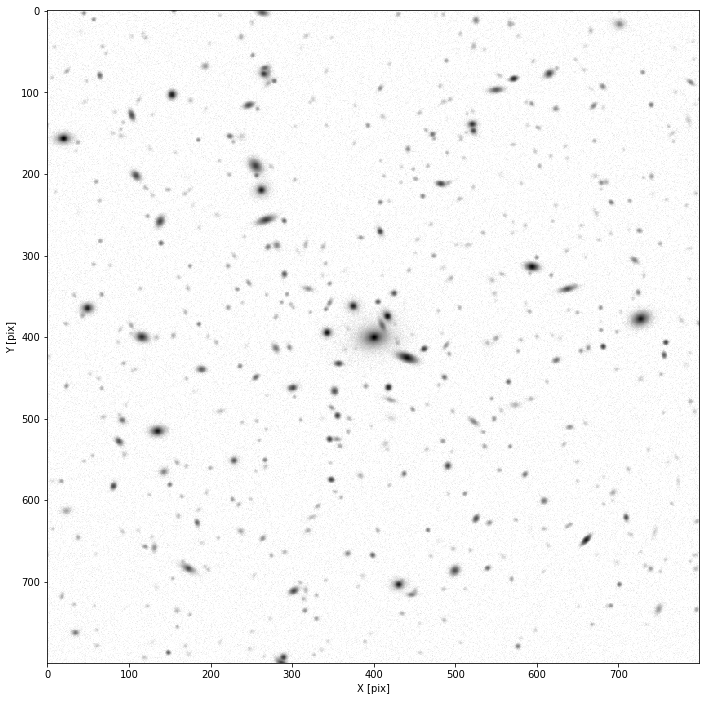

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
#cc = icl_arrs[2]
cc = df.canvas.array + noise
cc = cc[2100:2900, 2100:2900]
ax.imshow(images.asinh_scale(cc*0.01, 0.12) * 2, cmap=plt.cm.gray_r)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

In [101]:
arr = df.canvas.array + noise
#arr = arr[2100:2900, 2100:2900]
fio.write("test.fits", arr, clobber=True)

In [224]:
cat = fio.read("test.cat.fits")
seg = fio.read("seg.fits")

In [225]:
# sel = cat['FLAGS'] == 0

In [385]:
ids = cat['NUMBER']
cens = np.vstack((cat['X_IMAGE'], cat['Y_IMAGE'])).T

In [398]:
cens[:10]

array([[2510.7627 ,  223.42908],
       [2517.8232 ,  238.31033],
       [2549.0977 ,  224.19153],
       [2474.0693 ,  221.76088],
       [2369.6577 ,  228.74889],
       [2438.2668 ,  262.41724],
       [2589.7488 ,  228.51491],
       [2352.9832 ,  237.59633],
       [2468.7878 ,  232.29459],
       [2264.009  ,  242.1072 ]], dtype=float32)

In [410]:
class Shear(object):
    def __init__(self, canvas, image_epsf, maskmap):
        self.canvas = canvas.copy()
        self.image_epsf = image_epsf
        self.BADVAL = -9999
        self.maskmap = galsim.ImageI(maskmap).copy()
        
    def extract_stamps(self, centers, imasks, size=32):
        half_size = size // 2
        self.stamps = []
        self.masks = []
        for i in np.arange(len(centers[:10])):
            cen = centers[i]
            bb = galsim.bounds.BoundsI(np.round(cen[0]) - half_size,
                                       np.round(cen[0]) + half_size - 1,
                                       np.round(cen[1]) - half_size,
                                       np.round(cen[1]) + half_size - 1)
            stamp = self.canvas[bb].array.copy()
            mask = self.maskmap[bb].array.copy()
            mm = (mask.array != imasks[i]) & (mask.array != 0)
            mm = (mask != imasks[i]) & (mask != 0)
            muniques = np.unique(mask)
            print(np.unique(mask), imasks[i], bb)
            stamp[mm] = 0
            mask[mm] = 0
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.imshow(stamp)
            ax.set_title(str(i) + " " + str(muniques) + " " +str(imasks[i]))
#             
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.imshow(mask)
#             
            self.masks.append(mask)
            self.stamps.append(stamp)


    def estimate_shear(self, sky_var=0, shear_est="KSB", which="canvas"):
        """
        shear modes = REGAUSS’, ‘LINEAR’, ‘BJ’, or ‘KSB’
        which is raw or canvas, default to canvas
        """
        
        stamps = self.raw_stamps
        if which == "canvas":
            stamps = self.stamps
        
        self.logs = []
        self.shears = []
        self.success = []
        self.fluxes = []
        self.shears_error = []
        for i, im in enumerate(stamps):
            try:
                res = galsim.hsm.EstimateShear(im, self.image_epsf, shear_est=shear_est, sky_var=sky_var)
                self.logs.append(res)
                
                tmp = np.array([res.corrected_g1, res.corrected_g2])
                
                self.shears.append(tmp)
                self.fluxes.append(res.moments_amp * (self.drawer.pixel_scale)**2)
                self.shears_error.append(res.corrected_shape_err)
                self.success.append(True)
#                 print("here")
            except:
                self.logs.append(None)
                self.fluxes.append(None)
                tmp = np.array([self.BADVAL, self.BADVAL])
                self.shears.append(tmp)
                self.shears_error.append(None)
                self.success.append(False)
                
                
               
        self.fluxes = np.array(self.fluxes)
        self.shears = np.array(self.shears)
        self.success = np.array(self.success)
        self.shears_error = np.array(self.shears_error)



In [ ]:
np.unique(seg).shape

In [407]:
ids.shape

(10636,)

In [408]:
np.where(seg == 9)

(array([229, 229, 229, 230, 230, 230, 230, 231, 231, 231, 231, 231, 232,
        232, 232, 232, 232, 233, 233, 233, 233, 234, 234]),
 array([2466, 2467, 2468, 2466, 2467, 2468, 2469, 2466, 2467, 2468, 2469,
        2470, 2466, 2467, 2468, 2469, 2470, 2467, 2468, 2469, 2470, 2467,
        2468]))

In [409]:
sc = Shear(df.canvas, df.image_epsf, seg)
sc.extract_stamps(cens, imasks=ids, size=32)

[0 1 2] 1 galsim.BoundsI(2495,2526,207,238)
[0 1 2] 2 galsim.BoundsI(2502,2533,222,253)
[0 3] 3 galsim.BoundsI(2533,2564,208,239)
[0 4 9] 4 galsim.BoundsI(2458,2489,206,237)
[0 5 8] 5 galsim.BoundsI(2354,2385,213,244)
[ 0  6 13 25] 6 galsim.BoundsI(2422,2453,246,277)
[0 7] 7 galsim.BoundsI(2574,2605,213,244)
[0 5 8] 8 galsim.BoundsI(2337,2368,222,253)
[0 4 9] 9 galsim.BoundsI(2453,2484,216,247)
[ 0 10] 10 galsim.BoundsI(2248,2279,226,257)


In [347]:
mask = sc.masks[3].array.copy()
print(np.unique(mask))
stamp = sc.stamps[3].array.copy()
mm = (mask != 6) & (mask != 0)
stamp[mm] = 0

[ 0  6 13 25]


In [351]:
ids[1]

4

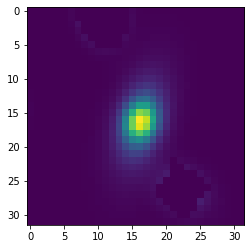

In [348]:
plt.imshow(stamp)